In [4]:
import numpy as np
from keras.models import Model,load_model,Sequential
from keras.layers import Input,Dense,Activation,Flatten,BatchNormalization,Conv2D,ZeroPadding2D
from keras.layers import MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing import image

In [5]:
import os
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



In [7]:
from keras.utils import np_utils
from keras.utils import layer_utils
from keras.utils import plot_model
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG


In [36]:
path1="C:\dataset 2"


In [37]:
listing=os.listdir(path1)

In [38]:
for file in listing:
    im=Image.open(path1 +'\\'+ file)
    im=im.resize((64,64))
    im.save(path1 + '\\'+ file,"JPEG")

In [39]:
immatrix=np.array([np.array(Image.open('C:\dataset 2'+ '\\'+im)).flatten() for im in listing],'f')

In [40]:
immatrix.shape

(56, 12288)

In [41]:
label=np.ones((immatrix.shape[0],),dtype=int)

In [42]:
label[0:14]=0
label[14:25]=1
label[25:36]=2
label[36:49]=3
label[49:]=4

In [43]:
data,label=shuffle(immatrix,label,random_state=2)

In [44]:
train_data=[data,label]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


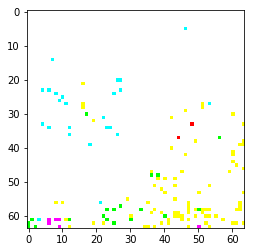

In [46]:
img=immatrix[1].reshape(64,64,3)
plt.imshow(img)

In [47]:
print(train_data[0].shape)
print(train_data[1].shape)

(56, 12288)
(56,)


In [48]:
x,y=(train_data[0],train_data[1])

In [49]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.4,random_state=2)

In [50]:
x_train=x_train.reshape(x_train.shape[0],64,64,3)
x_test=x_test.reshape(x_test.shape[0],64,64,3)

In [51]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

In [52]:
x_train/=255
x_test/=255

In [53]:
print(x_train.shape)
print(x_test.shape)

(33, 64, 64, 3)
(23, 64, 64, 3)


In [54]:
y_train=np_utils.to_categorical(y_train,5)
y_test=np_utils.to_categorical(y_test,5)

In [55]:
print(y_train.shape)
print(y_test.shape)

(33, 5)
(23, 5)


In [68]:
from keras.initializers import glorot_uniform
from keras.layers import Add

In [92]:
def identity_block(x,f,filters,stage,block):
    
    conv_name_base='res'+str(stage)+block+ 'branch'
    bn_name_base='bn'+str(stage)+block+ 'branch'
    
    
    f1,f2,f3=filters
    
    # Save the input value. You'll need this later to add back to the main path.
    x_shortcut=x
    
    # First component of main path
    x=Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3,name=bn_name_base+'2a')(x)
    x=Activation('relu')(x)
    
    # Second component of main path
    x=Conv2D(filters=f2,kernel_size=(f,f),strides=(1,1),padding="same",name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3,name=bn_name_base+'2b')(x)
    x=Activation('relu')(x)
    
    # Third component of main path
    x=Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3,name=bn_name_base+'2c')(x)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    x=Add()([x,x_shortcut])
    x=Activation('relu')(x)
    
    
    return x

    



In [93]:
def conv_block(x,f,filters,stage,block,s=2):
    
    conv_name_base='res'+str(stage)+block+'branch'
    bn_name_base='bn'+str(stage)+block+'branch'
    
    f1,f2,f3=filters
    
    x_shortcut=x
    
    # First component of main path
    x=Conv2D(filters=f1,kernel_size=(1,1),strides=(s,s),padding="valid",name=conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3,name=bn_name_base+'2a')(x)
    x=Activation('relu')(x)
    
    # 2nd component of main path
    x=Conv2D(filters=f2,kernel_size=(f,f),strides=(1,1),padding="same",name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3,name=bn_name_base+'2b')(x)
    x=Activation('relu')(x)
    
    # Third component of main path
    x=Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3,name=bn_name_base+'2c')(x)
    
    #shortcut path
    x_shortcut=Conv2D(filters=f3,kernel_size=(1,1),strides=(s,s),padding='valid',name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(x_shortcut)
    x_shortcut=BatchNormalization(axis=3, name=bn_name_base + '1')(x_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    x=Add()([x,x_shortcut])
    x=Activation('relu')(x)
    
    
    return x

    
    
    
    
    


In [94]:
def resnet50(input_shape=(64,64,3),classes=5):
    
    x_input=Input(input_shape)
    
    x=ZeroPadding2D((3,3))(x_input)
    
    # Stage 1
    x=Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(x)
    x=BatchNormalization(axis=3, name='bn_conv1')(x)
    x=Activation('relu')(x)
    x=MaxPooling2D((3,3),strides=(2,2))(x)
    
    # Stage 2
    x=conv_block(x,f=3,filters=[64,64,256],stage=2,block='a',s=1)
    x=identity_block(x,3,[64,64,256],stage=2,block='b')
    x=identity_block(x,3,[64,64,256],stage=2,block='c')
    
    # Stage 3
    x=conv_block(x,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    x=identity_block(x,3,[128,128,512],stage=3,block='b')
    x=identity_block(x,3,[128,128,512],stage=3,block='c')
    x=identity_block(x,3,[128,128,512],stage=3,block='d')
    
    # Stage 4
    x=conv_block(x,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
    x=identity_block(x,3,[256,256,1024],stage=4,block='b')
    x=identity_block(x,3,[256,256,1024],stage=4,block='c')
    x=identity_block(x,3,[256,256,1024],stage=4,block='d')
    x=identity_block(x,3,[256,256,1024],stage=4,block='e')
    x=identity_block(x,3,[256,256,1024],stage=4,block='f')
    
    # Stage 5
    x=conv_block(x,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    x=identity_block(x,3,[512,512,2048],stage=5,block='b')
    x=identity_block(x,3,[512,512,2048],stage=5,block='c')
    
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    
    x=Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(x)
    
    # Create model
    model=Model(inputs=x_input,outputs=x,name='resnet50')
    
    
    return model







    

    
    

In [95]:
model=resnet50(input_shape=(64,64,3),classes=5)

In [96]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [101]:
model.fit(x_train, y_train, epochs = 100, batch_size = 11)


Epoch 1/100
33/33 [==============================] - 5s 151ms/step - loss: 8.5887e-04 - acc: 1.0000
Epoch 2/100
33/33 [==============================] - 5s 149ms/step - loss: 0.0076 - acc: 1.0000
Epoch 3/100
33/33 [==============================] - 5s 149ms/step - loss: 0.4974 - acc: 0.9394
Epoch 4/100
33/33 [==============================] - 5s 149ms/step - loss: 0.1851 - acc: 0.9394
Epoch 5/100
33/33 [==============================] - 5s 149ms/step - loss: 0.2383 - acc: 0.9091
Epoch 6/100
33/33 [==============================] - 5s 151ms/step - loss: 0.0041 - acc: 1.0000
Epoch 7/100
33/33 [==============================] - 6s 169ms/step - loss: 0.2510 - acc: 0.9091
Epoch 8/100
33/33 [==============================] - 5s 157ms/step - loss: 0.1699 - acc: 0.9697
Epoch 9/100
33/33 [==============================] - 5s 152ms/step - loss: 0.3170 - acc: 0.9091
Epoch 10/100
33/33 [==============================] - 5s 149ms/step - loss: 0.0111 - acc: 1.0000
Epoch 11/100
33/33 [===============

33/33 [==============================] - 5s 156ms/step - loss: 0.1426 - acc: 0.9697
Epoch 86/100
33/33 [==============================] - 5s 151ms/step - loss: 0.3432 - acc: 0.8788
Epoch 87/100
33/33 [==============================] - 5s 152ms/step - loss: 0.2205 - acc: 0.9091
Epoch 88/100
33/33 [==============================] - 5s 151ms/step - loss: 7.3493e-04 - acc: 1.0000
Epoch 89/100
33/33 [==============================] - 5s 150ms/step - loss: 0.1232 - acc: 0.9697
Epoch 90/100
33/33 [==============================] - 5s 149ms/step - loss: 1.9820e-04 - acc: 1.0000
Epoch 91/100
33/33 [==============================] - 5s 149ms/step - loss: 0.1530 - acc: 0.9394
Epoch 92/100
33/33 [==============================] - 5s 149ms/step - loss: 0.0031 - acc: 1.0000
Epoch 93/100
33/33 [==============================] - 5s 148ms/step - loss: 0.0011 - acc: 1.0000
Epoch 94/100
33/33 [==============================] - 5s 149ms/step - loss: 0.0828 - acc: 0.9697
Epoch 95/100
33/33 [===============

In [102]:
score=model.evaluate(x_test,y_test)
print("test score",score[0])
print("test accuracy",score[1])


23/23 [==============================] - 1s 29ms/step
test score 4.26244878769
test accuracy 0.391304343939


In [103]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 70, 70, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation